In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *


# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_nexus.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_1mm_smear.h5',"MC/hits")
# hits = pd.read_hdf('../../NEXT_nudobe/files/data/Leptoquark_SM_4mm_smear.h5',"MC/hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_1mmstep_high_E_slim_smear.h5","hits")


# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_gamma_SF0_779551_24.h5", "hits")

# hits = pd.read_hdf("../../NEXT_nudobe/files/data/mbb_0_1mm_smear.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_0nubb/newfiles/ATPC_0nubb_1bar_smear_144.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_gamma/ATPC_Tl_1bar_smear_1384.h5", "MC/hits")

hits = pd.read_hdf("../job/test/ATPC_0nubb_1bar_smear_9.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_SF0_779552_232.h5", "hits")

display(hits)
print(hits.event_id.unique())


,event_id,x,y,z,energy
0,500,2712.364746,553.651123,3449.056152,0.000595
1,500,2712.877686,563.317688,3449.185791,0.002108
2,500,2711.479248,566.225647,3449.192871,0.000719
3,500,2713.127197,561.488586,3449.413574,0.003125
4,500,2711.796387,549.282654,3449.558105,0.002133
...,...,...,...,...,...
21325,520,1032.451538,-1962.421021,2663.068359,0.000025
21326,520,1029.390625,-1964.138062,2663.427979,0.004662
21327,520,1024.917480,-1966.743652,2663.754150,0.002480
21328,520,1022.708923,-1967.982422,2663.866455,0.000273


[500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520]


,event_id,x,y,z,energy
0,516,-1475.032227,1886.077148,736.186768,0.001290
1,516,-1475.014038,1887.936768,736.894775,0.000422
2,516,-1474.978760,1876.636230,729.462402,0.005630
3,516,-1474.938477,1873.642700,726.764832,0.000248
4,516,-1474.811646,1878.717651,731.600098,0.008159
...,...,...,...,...,...
982,516,-665.685059,1913.454468,341.326721,0.004638
983,516,-663.963135,1924.454224,338.547882,0.003125
984,516,-662.759094,1922.108887,338.175537,0.000322
985,516,-662.302307,1917.275391,338.510284,0.000198


Median distance to the closest row: 2.5990357923368124


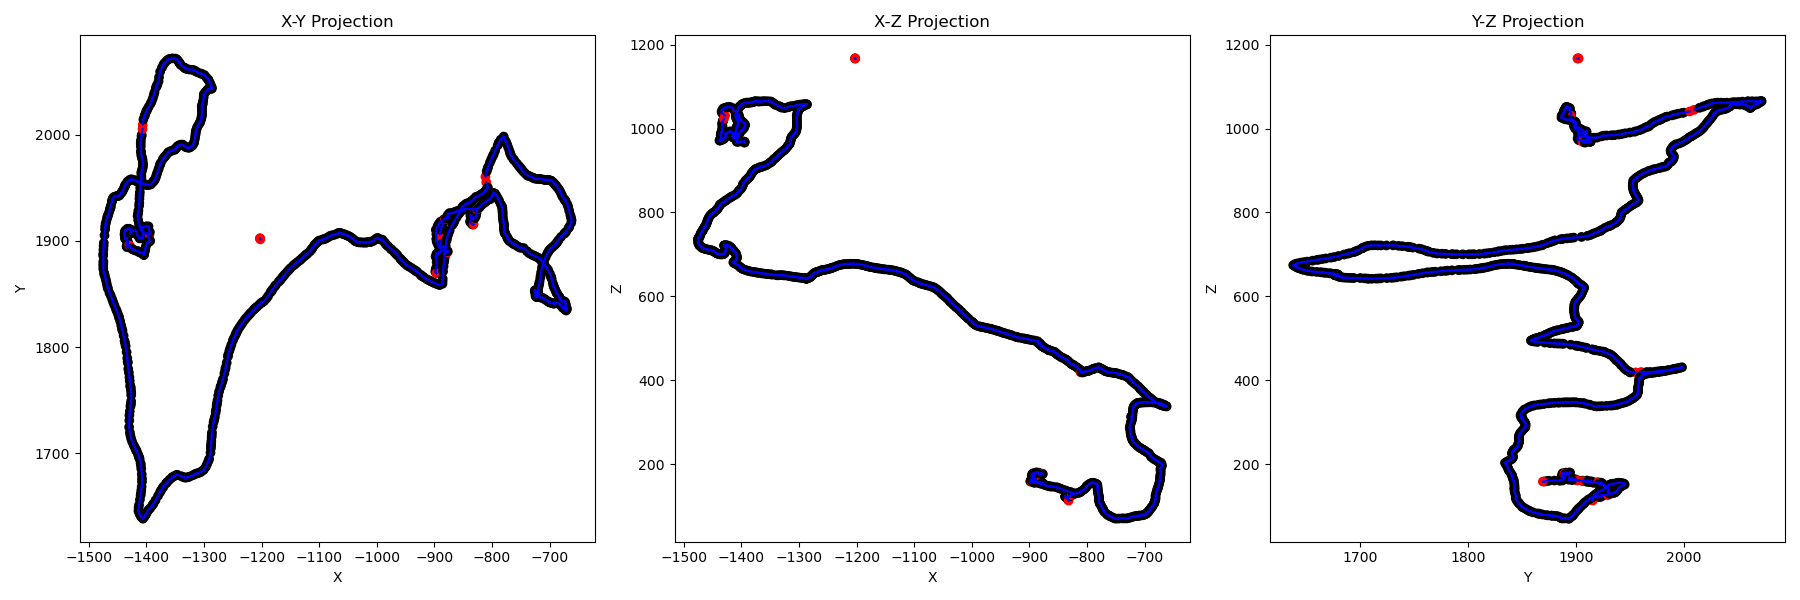

In [195]:
%matplotlib widget

data = hits[hits.event_id ==516]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Mean_dist = GetMeanNodeDistances(data) # Mean distance between nodes
init_dist_thresh = Mean_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Mean_dist*5, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_75003/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': 102, 'end': 113, 'nodes': [102, 98, 95, 94, 87, 84, 91, 86, 82, 81, 78, 76, 75, 72, 74, 77, 73, 66, 62, 64, 69, 89, 104, 114, 126, 119, 127, 124, 118, 121, 137, 141, 144, 149, 153, 172, 180, 210, 220, 231, 229, 235, 242, 245, 252, 261, 267, 269, 273, 274, 268, 259, 254, 248, 246, 243, 239, 237, 236, 234, 224, 212, 189, 169, 158, 151, 142, 138, 135, 103, 96, 85, 79, 83, 100, 113], 'length': 247.057, 'energy': 0.2559360003651818, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 2, 'start': 221, 'end': 270, 'nodes': [221, 207, 201, 187, 184, 185, 190, 191, 198, 211, 217, 222, 226, 228, 225, 219, 215, 202, 196, 199, 200, 192, 183, 178, 175, 171, 168, 167, 166, 159, 155, 154, 157, 163, 176, 193, 208, 216, 204, 209, 230, 253, 265, 271, 272, 270], 'length': 158.058, 'energy': 0.20306240041099954, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 3, 'start': 223, 'end': 742, 'nodes': [223

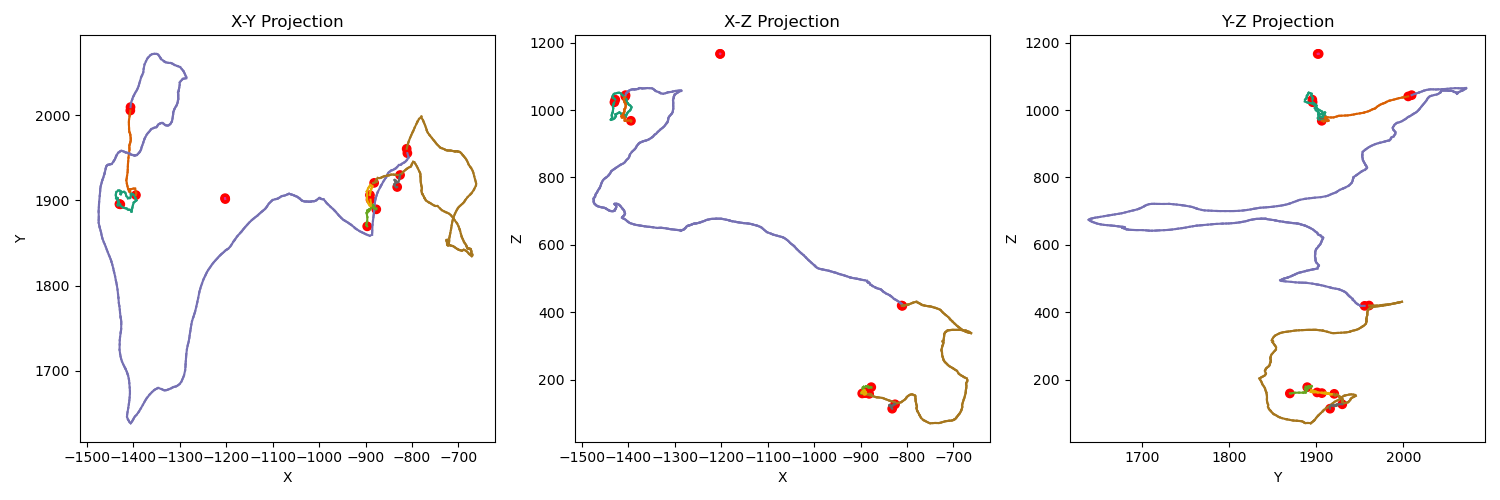

In [196]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [197]:
print(GetMeanNodeDist(Tracks, data))

dist_threshold = 4*GetMeanNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.335
Dist Thresh 13.34


In [198]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [199]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
Loop:  3
Loop:  4
True
Total Tracks: 6
{'id': 0, 'start': 102, 'end': 113, 'nodes': [102, 98, 95, 94, 87, 84, 91, 86, 82, 81, 78, 76, 75, 72, 74, 77, 73, 66, 62, 64, 69, 89, 104, 114, 126, 119, 127, 124, 118, 121, 137, 141, 144, 149, 153, 172, 180, 210, 220, 231, 229, 235, 242, 245, 252, 261, 267, 269, 273, 274, 268, 259, 254, 248, 246, 243, 239, 237, 236, 234, 224, 212, 189, 169, 158, 151, 142, 138, 135, 103, 96, 85, 79, 83, 100, 113], 'length': 247.057, 'energy': 0.2559360003651818, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 5, 'start': 479, 'end': 480, 'nodes': [479, 478, 480], 'length': 1.319, 'energy': 0.03186800004914403, 'label': 'track', 'c': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)}
{'id': 12, 'start': 718, 'end': 727, 'nodes': [718, 716, 713, 706, 702, 703, 707, 710, 704, 708, 714, 717, 720, 723, 724, 727, 728], 'length': 43.479, 'energy': 0.1047304011444794, 'label': 'track', 'c'

{'id': 0, 'start': 270, 'end': 668, 'length': 2885.527, 'energy': 1.9689960043760948, 'label': 'Primary', 'c': 'Teal', 'nodes': [270, 272, 271, 265, 253, 230, 209, 204, 216, 208, 193, 176, 163, 157, 154, 155, 159, 166, 167, 168, 171, 175, 178, 183, 192, 200, 199, 196, 202, 215, 219, 225, 228, 226, 222, 217, 211, 198, 191, 190, 185, 184, 187, 201, 207, 221, 223, 232, 241, 244, 249, 255, 258, 266, 277, 279, 282, 285, 287, 291, 293, 295, 298, 300, 303, 307, 311, 313, 317, 321, 326, 330, 335, 338, 340, 341, 343, 348, 351, 352, 354, 359, 364, 369, 373, 380, 387, 391, 409, 412, 417, 419, 421, 424, 432, 431, 422, 416, 415, 414, 410, 407, 406, 405, 404, 403, 402, 400, 392, 395, 397, 396, 394, 398, 399, 393, 390, 389, 388, 385, 384, 382, 381, 379, 377, 376, 375, 374, 372, 370, 368, 367, 366, 363, 362, 360, 358, 356, 353, 349, 346, 345, 342, 339, 337, 334, 332, 331, 329, 325, 323, 320, 319, 316, 314, 312, 309, 305, 304, 301, 299, 297, 294, 292, 290, 288, 286, 284, 281, 278, 276, 263, 262, 260, 2

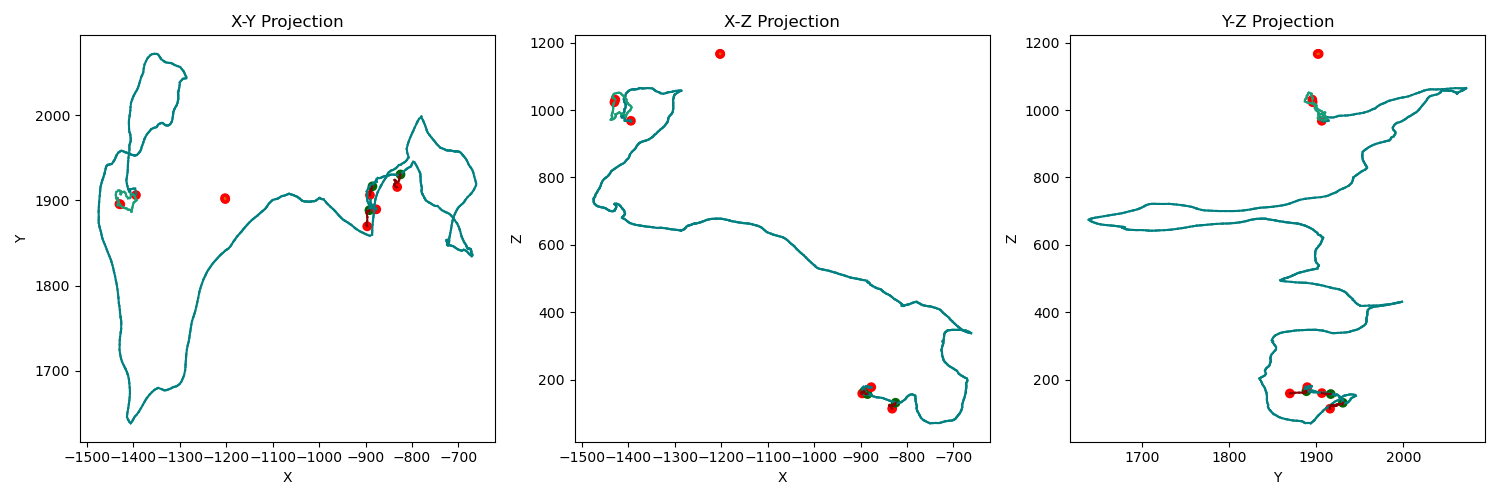

In [200]:
def RebuildTracks(connected_nodes_, connection_count_, data):

    RebuiltTrack_ = []
    Track_arrays = []
    Accounted_nodes = []
    track_nodes = []

    data_nodes = data.index.values.tolist()
    remaining_nodes = data_nodes
    trk_ids = 0
    i = 0
    
    # Loop over and build tracks
    while remaining_nodes:
        RebuildTracks_, remaining_nodes, trk_ids = MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, i, trk_ids, RebuiltTrack_)
        i = i + 1

    # Quality control
    track_nodes = []
    e_sum = 0
    for t in RebuiltTrack_:
        e_sum = e_sum+t["energy"]
        track_nodes = track_nodes + t["nodes"]


    ratio = e_sum / data.energy.sum()

    if (ratio < 0.999 or ratio > 1.0001):
        print("Ratio is off:", ratio)
        return RebuiltTrack_, False

    are_equal = set(track_nodes) == set(data_nodes)

    if (not are_equal):
        print("Missing Nodes:", set(data_nodes) - set(track_nodes))
        return RebuiltTrack_, False

    return RebuiltTrack_, True


def MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, iteration, trk_ids, RebuiltTrack_):

    Track_arrays = []

    prim_track_id = -1
    prim_len = 0
    prim_track_arr = []
    prim_energy = 0

    # Get all nodes with single connections
    end_points = np.where(connection_count_ == 1)[0]
    end_points = [x for x in end_points if x in remaining_nodes]

    if (iteration == 0):
        primary_label = "Primary"
        delta_label = "Delta"
        color = "Teal"
    else:
        primary_label = "Brem"
        delta_label = "BremDelta"
        color = next(color_cycle)

    for index, end_point in enumerate(end_points):
        trkpath = GetLongestPath(connected_nodes_, end_point)
        Track_arrays.append(trkpath)

        trk_length = GetTrackLength(trkpath, data)

        if (trk_length > prim_len):
            prim_len = trk_length
            prim_track_id = index
            prim_track_arr = trkpath
            prim_energy = GetTrackEnergy(trkpath, data, False)
    
    # Create the primary track
    RebuiltTrack_.append({"id":trk_ids, "start":prim_track_arr[0], "end":prim_track_arr[-1], "length":trk_length, "energy":prim_energy, "label":primary_label, "c":color, "nodes":prim_track_arr})
    trk_ids = trk_ids + 1

    # Get all nodes with three connections in the primary track
    multi_connections = np.where(connection_count_ == 3)[0]
    prim_track_multi_connections = [x for x in multi_connections if x in prim_track_arr]

    for node in prim_track_multi_connections:
        delta_node = [x for x in connected_nodes_[node] if x not in prim_track_arr]

        if (len(delta_node) > 1):
            print("Error the delta node has more than one node after cut")

        delta_paths = GetDeltaPath(connected_nodes_, node , delta_node[0], 0)
    
        for t in range(len(delta_paths)):
            trkpath = delta_paths[t]
            trk_energy = GetTrackEnergy(trkpath, data, True)
            trk_length = GetTrackLength(trkpath, data)
            RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":trk_length, "energy":trk_energy, "label":f"{delta_label}{t}", "c":"DarkRed", "nodes":trkpath})
            trk_ids = trk_ids + 1


    # This is for single nodes
    single_points = np.where(connection_count_ == 0)[0]
    single_points = [x for x in single_points if x in remaining_nodes] # Removes ones that have already been added

    for index, single_point in enumerate(single_points):
        trkpath = [single_point]
        energy = GetTrackEnergy(trkpath, data, False)
        RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":0, "energy":energy, "label":"Brem", "c":"Orange", "nodes":trkpath})
        trk_ids = trk_ids + 1


    track_nodes = []
    for t in RebuiltTrack_:
        track_nodes = track_nodes + t["nodes"]
    remaining_nodes = list(set(data_nodes) - set(track_nodes))

    return RebuiltTrack_, remaining_nodes, trk_ids



RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [201]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
0,516,-1394.691162,1906.165771,968.256653,0.034918,270,1,0,0.000000,0.000000
1,516,-1394.235352,1908.467407,968.406006,0.016021,272,1,0,2.351084,92.049660
2,516,-1394.514893,1908.463867,966.195496,0.013888,271,1,0,4.579202,95.100437
3,516,-1396.403198,1913.746826,969.046082,0.004861,265,1,0,10.872150,114.398997
4,516,-1399.865479,1913.830688,969.031189,0.002926,253,1,0,14.335478,71.436443
...,...,...,...,...,...,...,...,...,...,...
982,516,-1430.760132,1895.769165,1034.640625,0.002083,100,0,4,242.627119,48.677083
983,516,-1428.403564,1895.328613,1030.915527,0.007738,113,0,4,247.057000,27.639973
984,516,-1202.694580,1902.615967,1167.052246,0.004365,479,0,5,0.000000,0.000000
985,516,-1202.733154,1902.283936,1167.125488,0.015202,478,0,5,0.342195,140.991377


{0: [1, 5], 1: [0, 6], 2: [4, 3], 4: [2, 5], 3: [2, 9], 5: [4, 0], 6: [7, 1], 7: [6, 8], 8: [7, 11], 9: [10, 3], 10: [9, 12], 12: [10, 15], 13: [14, 11], 14: [13, 16], 15: [18, 12], 18: [15, 19], 16: [17, 14], 17: [16, 20], 19: [18, 22], 20: [21, 17], 21: [20, 23], 23: [21, 24], 22: [25, 19], 25: [22, 27], 24: [23, 26], 26: [28, 24], 28: [26, 29], 27: [31, 25], 31: [27, 35], 29: [28, 30], 30: [29, 32], 32: [30, 33], 33: [34, 32], 34: [33, 36], 35: [38, 31], 38: [35, 41], 36: [34, 37], 37: [39, 36], 39: [37, 40], 40: [42, 39], 42: [40, 44], 41: [38, 43], 44: [42, 46], 43: [45, 41], 45: [43, 47], 46: [44, 48], 48: [46, 51], 47: [49, 45], 49: [47, 50], 50: [49, 52], 51: [48, 54], 52: [50, 53], 53: [55, 52], 55: [53, 58], 54: [56, 51], 56: [54, 57], 58: [55, 60], 57: [56, 59], 59: [57, 61], 60: [58, 63], 61: [65, 59], 65: [61, 68], 62: [64, 66], 64: [62, 69], 63: [67, 60], 67: [63, 71], 69: [64, 89], 68: [65, 70], 66: [62, 73], 70: [68, 90], 71: [67, 80], 72: [74, 75], 74: [72, 77], 73: [7

Text(0, 0.5, 'Scatter Angle [deg]')

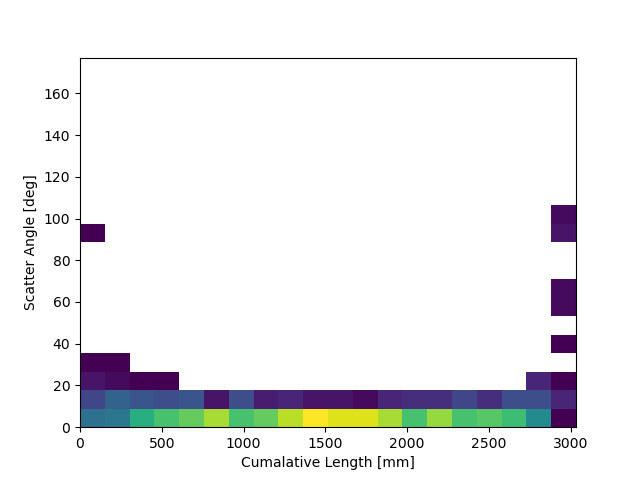

In [202]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

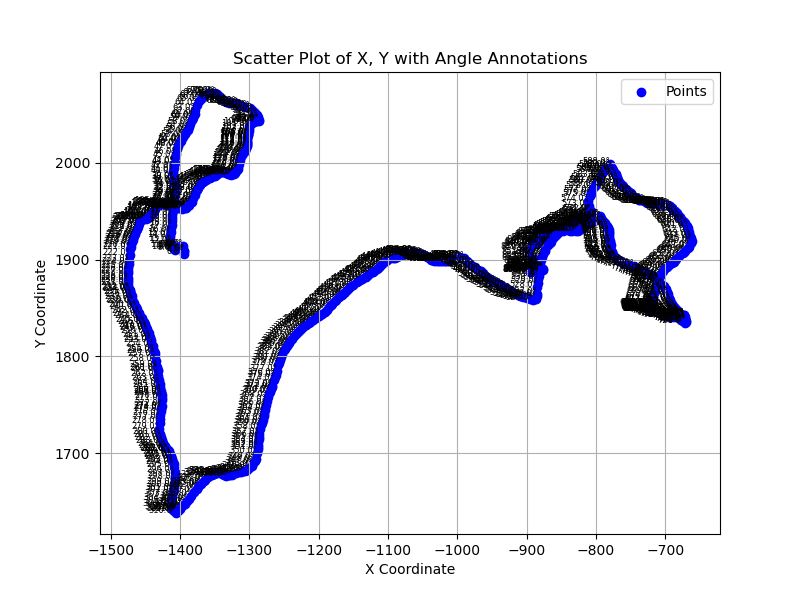

In [203]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [204]:
# Calculate Track Tortuosity

df_angles = CalcTortuosity(df_angles)

In [205]:
display(df_angles)

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity
0,516,-1394.691162,1906.165771,968.256653,0.034918,270,1,0,0.000000,0.000000,1.961401
1,516,-1394.235352,1908.467407,968.406006,0.016021,272,1,0,2.351084,92.049660,1.838366
2,516,-1394.514893,1908.463867,966.195496,0.013888,271,1,0,4.579202,95.100437,1.871834
3,516,-1396.403198,1913.746826,969.046082,0.004861,265,1,0,10.872150,114.398997,1.832237
4,516,-1399.865479,1913.830688,969.031189,0.002926,253,1,0,14.335478,71.436443,1.782603
...,...,...,...,...,...,...,...,...,...,...,...
982,516,-1430.760132,1895.769165,1034.640625,0.002083,100,0,4,242.627119,48.677083,1.208909
983,516,-1428.403564,1895.328613,1030.915527,0.007738,113,0,4,247.057000,27.639973,1.161517
984,516,-1202.694580,1902.615967,1167.052246,0.004365,479,0,5,0.000000,0.000000,1.082314
985,516,-1202.733154,1902.283936,1167.125488,0.015202,478,0,5,0.342195,140.991377,1.082314


878


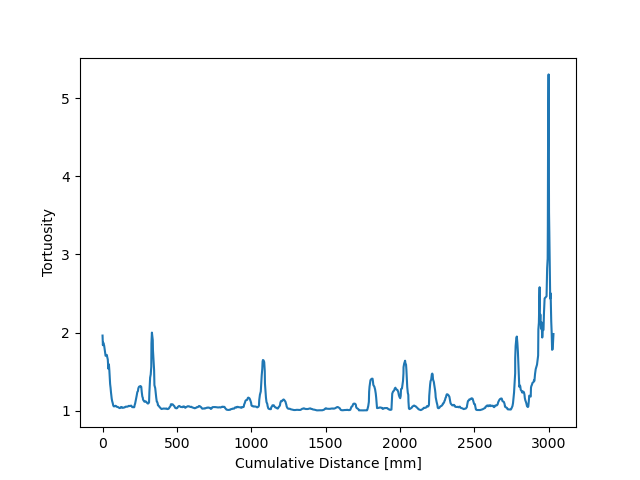

In [206]:
plt.figure()

plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Tortuosity")

# plt.figure()

# plt.hist(df_angles[df_angles.trkID == 0].cumulative_distance, weights = df_angles[df_angles.trkID == 0].energy, bins = 20)
# plt.xlabel("Cumulative Distance [mm]")
# plt.ylabel("Energy [MeV]")


print(len(df_angles[df_angles.trkID == 0]))

In [207]:

Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 200)

display(Track_df)

print(Track_df.energy.sum())



,event_id,trkID,primary,start,end,length,energy,blob1,blob2,Tortuosity1,Tortuosity2,label
0,516,0,1,270,668,2885.527,1.968996,0.431123,0.404488,1.940500,1.235077,Primary
0,516,1,0,628,612,28.913,0.089206,0.089206,0.089206,1.354789,1.354789,Delta0
0,516,2,0,646,632,12.215,0.012326,0.012326,0.012326,1.021867,1.021867,Delta0
0,516,3,0,728,718,48.176,0.104730,0.104730,0.104730,1.892709,1.892709,Delta0
0,516,4,0,102,113,1.319,0.255936,0.255936,0.255936,1.497905,1.422086,Brem
0,516,5,0,479,480,1.319,0.031868,0.031868,0.031868,1.082314,1.082314,Brem


2.463061605769326


In [212]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


1
Adding trk 1 Delta0 energy to blob2 as dist was 19.045011520385742
2
Adding trk 2 Delta0 energy to blob2 as dist was 34.8570442199707
3
Adding trk 3 Delta0 energy to blob2 as dist was 80.94366455078125
4
Adding Brem energy to blob1 as dist was 66.47266387939453
5
T1:  [1.9405001203957537, 1.4979051946132125]


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,Tortuosity1,Tortuosity2,label
0,516,0,1,270,668,2885.527,1.968996,0.687059,0.610750,1.719203,2.752221,Primary
0,516,1,0,628,612,28.913,0.089206,0.089206,0.089206,1.354789,1.354789,Delta0
0,516,2,0,646,632,12.215,0.012326,0.012326,0.012326,1.021867,1.021867,Delta0
0,516,3,0,728,718,48.176,0.104730,0.104730,0.104730,1.892709,1.892709,Delta0
0,516,4,0,102,113,1.319,0.255936,0.255936,0.255936,1.497905,1.422086,Brem
0,516,5,0,479,480,1.319,0.031868,0.031868,0.031868,1.082314,1.082314,Brem
